### Importando as bibliotecas necessárias

In [ ]:
import os
import re
import boto3
import pandas as pd
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from acessar_dados_curated import carregar_parquets_em_variaveis, acessar_parquet_s3
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Carregando os dados da camada Silver em DataFrames

In [3]:
carregar_parquets_em_variaveis(destino=globals(), nomes=["clientes_desde", "codigos_paises","contratacoes_ultimos_12_meses", "dados_clientes","historico",
                                                          "mrr","nps_relacional", "nps_transacional_aquisicao","nps_transacional_implantacao", 
                                                          "nps_transacional_onboarding","nps_transacional_produto", "nps_transacional_suporte",
                                                          "tickets", "telemetria_consolidado"])

clientes_desde ← silver/clientes_desde.parquet  | 10615 linhas
codigos_paises ← silver/codigos_paises.parquet  | 249 linhas
contratacoes_ultimos_12_meses ← silver/contratacoes_ultimos_12_meses.parquet  | 4314 linhas
dados_clientes ← silver/dados_clientes.parquet  | 238597 linhas
historico ← silver/historico.parquet  | 22740 linhas
mrr ← silver/mrr.parquet  | 7309 linhas
nps_relacional ← silver/nps_relacional.parquet  | 13942 linhas
nps_transacional_aquisicao ← silver/nps_transacional_aquisicao.parquet  | 175 linhas
nps_transacional_implantacao ← silver/nps_transacional_implantacao.parquet  | 662 linhas
nps_transacional_onboarding ← silver/nps_transacional_onboarding.parquet  | 208 linhas
nps_transacional_produto ← silver/nps_transacional_produto.parquet  | 113201 linhas
nps_transacional_suporte ← silver/nps_transacional_suporte.parquet  | 74794 linhas
tickets ← silver/tickets.parquet  | 976063 linhas
telemetria_consolidado ← silver/telemetria_consolidado.parquet  | 30804197 linhas


{'clientes_desde': 's3://arcana-fiap/silver/clientes_desde.parquet',
 'codigos_paises': 's3://arcana-fiap/silver/codigos_paises.parquet',
 'contratacoes_ultimos_12_meses': 's3://arcana-fiap/silver/contratacoes_ultimos_12_meses.parquet',
 'dados_clientes': 's3://arcana-fiap/silver/dados_clientes.parquet',
 'historico': 's3://arcana-fiap/silver/historico.parquet',
 'mrr': 's3://arcana-fiap/silver/mrr.parquet',
 'nps_relacional': 's3://arcana-fiap/silver/nps_relacional.parquet',
 'nps_transacional_aquisicao': 's3://arcana-fiap/silver/nps_transacional_aquisicao.parquet',
 'nps_transacional_implantacao': 's3://arcana-fiap/silver/nps_transacional_implantacao.parquet',
 'nps_transacional_onboarding': 's3://arcana-fiap/silver/nps_transacional_onboarding.parquet',
 'nps_transacional_produto': 's3://arcana-fiap/silver/nps_transacional_produto.parquet',
 'nps_transacional_suporte': 's3://arcana-fiap/silver/nps_transacional_suporte.parquet',
 'tickets': 's3://arcana-fiap/silver/tickets.parquet',
 

In [47]:
df_clientes_desde = clientes_desde
df_codigos_paises = codigos_paises
df_contratacoes_ultimos_12_meses = contratacoes_ultimos_12_meses
df_dados_clientes = dados_clientes
df_historico = historico
df_mrr = mrr
df_nps_relacional = nps_relacional
df_nps_transacional_aquisicao = nps_transacional_aquisicao
df_nps_transacional_implantacao = nps_transacional_implantacao
df_nps_transacional_onboarding = nps_transacional_onboarding
df_nps_transacional_produto = nps_transacional_produto
df_nps_transacional_suporte = nps_transacional_suporte
df_telemetria_consolidado = telemetria_consolidado
df_tickets = tickets

In [5]:
df_dados_clientes.head()

,COD_CLIENTE,DS_PROD,DS_LIN_REC,CIDADE_CLIENTE,DS_CNAE,DS_SEGMENTO,DS_SUBSEGMENTO,FAT_FAIXA,MARCA_TOTVS,MODAL_COMERC,PAIS_CLIENTE,PERIODICIDADE_COBRANCA,SIT_CONTRATO,UF_CLIENTE,VL_TOTAL_CONTRATO,DATA_ASSINATURA_CONTRATO
0,99958,SMS FULL TOTVS TRAD,SMS TOTVS SERIE T,JOINVILLE,PESSOA FISICA (SEM CNAE),SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,MODALIDADE TRADICIONAL,105,00 - Mensal,GRATUITO,SC,"1633817,36581438",2016-04-07
1,T00053,SMS COLAB NEO 2500 DOC,SMS TOTVS SERIE T,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,MANUFATURA - PARCEIRO,MODALIDADE TRADICIONAL,105,00 - Mensal,ATIVO,RJ,"341,155636978792",2015-02-27
2,T00053,HORA SUPORTE,CONSULTORIA TRADICIONAL,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,SERVICOS DE IMPLANTACAO,MODALIDADE SERVICOS NÃO RECORRENTES,105,00 - Mensal,CANCELADO,RJ,"45,3386017130146",1997-11-28
3,99958,CDU FULL TOTVS TRAD,CDU TOTVS SERIE T,JOINVILLE,PESSOA FISICA (SEM CNAE),SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,MODALIDADE TRADICIONAL,105,00 - Mensal,GRATUITO,SC,"42,0343698218297",2016-04-07
4,T00053,PROGRESS USER 11 CDU,CDU TOTVS SERIE T,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,PROGRESS,MODALIDADE TRADICIONAL,105,00 - Mensal,TROCADO,RJ,"0,117708006301753",2017-11-22


In [6]:
df_dados_clientes2 = df_dados_clientes.copy()

df_dados_clientes2 = (
    df_dados_clientes2.sort_values(["COD_CLIENTE","DATA_ASSINATURA_CONTRATO"])
      .drop_duplicates(subset=["COD_CLIENTE"], keep="last")[["COD_CLIENTE", "CIDADE_CLIENTE", "PAIS_CLIENTE", "UF_CLIENTE", "FAT_FAIXA", "DS_SEGMENTO", "DS_SUBSEGMENTO"]]
)

In [7]:
df_dados_clientes2

,COD_CLIENTE,CIDADE_CLIENTE,PAIS_CLIENTE,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO
65,99069,SAOPAULO,105,SP,Sem Informações de Faturamento,VAREJO,VAREJO
316,99958,JOINVILLE,105,SC,Faixa 09 - De 300 M ate 500 M,SERVICOS,PROVEDOR SERVICOS
15065,99999,SAOPAULO,105,SP,Sem Informações de Faturamento,TOTVS,TOTVS
37,CARAMU,ITUMBIARA,105,GO,Sem Informações de Faturamento,MANUFATURA,BENS DE CONSUMO
20105,T00018,SAOPAULO,105,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,VIAGENS
...,...,...,...,...,...,...,...
238589,TFEEXW,BELOHORIZONTE,105,MG,Faixa 08 - De 150 M ate 300 M,SAUDE,HOSPITAIS
203590,TFEEYC,GOIANIA,105,GO,Sem Informações de Faturamento,VAREJO,MODA
205241,TFEEYH,ITAITINGA,105,CE,Sem Informações de Faturamento,VAREJO,SUPERMERCADO
238593,TFEEYP,CANELA,105,RS,Sem Informações de Faturamento,HOSPITALITY,HOSPEDAGEM


In [8]:
df_codigos_paises

,CODIGO,PAIS
0,13,AFEGANISTAO
1,15,"ALAND, ILHAS"
2,17,"ALBANIA, REPUBLICA DA"
3,23,ALEMANHA
4,31,BURKINA FASO
...,...,...
244,866,"VIRGENS, ILHAS (E.U.A.)"
245,870,FIJI
246,875,"WALLIS E FUTUNA, ILHAS"
247,888,"CONGO, REPUBLICA DEMOCRATICA DO"


In [9]:
df_dados_clientes2 = df_dados_clientes2.merge(df_codigos_paises, left_on="PAIS_CLIENTE", right_on="CODIGO", how="left")

In [10]:
df_dados_clientes2 = df_dados_clientes2[["COD_CLIENTE", "CIDADE_CLIENTE", "PAIS", "UF_CLIENTE", "FAT_FAIXA", "DS_SEGMENTO", "DS_SUBSEGMENTO"]]

In [11]:
df_dados_clientes2

,COD_CLIENTE,CIDADE_CLIENTE,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO
0,99069,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,VAREJO,VAREJO
1,99958,JOINVILLE,BRASIL,SC,Faixa 09 - De 300 M ate 500 M,SERVICOS,PROVEDOR SERVICOS
2,99999,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,TOTVS,TOTVS
3,CARAMU,ITUMBIARA,BRASIL,GO,Sem Informações de Faturamento,MANUFATURA,BENS DE CONSUMO
4,T00018,SAOPAULO,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,VIAGENS
...,...,...,...,...,...,...,...
10610,TFEEXW,BELOHORIZONTE,BRASIL,MG,Faixa 08 - De 150 M ate 300 M,SAUDE,HOSPITAIS
10611,TFEEYC,GOIANIA,BRASIL,GO,Sem Informações de Faturamento,VAREJO,MODA
10612,TFEEYH,ITAITINGA,BRASIL,CE,Sem Informações de Faturamento,VAREJO,SUPERMERCADO
10613,TFEEYP,CANELA,BRASIL,RS,Sem Informações de Faturamento,HOSPITALITY,HOSPEDAGEM


In [12]:
df_cliente = df_clientes_desde.merge(df_dados_clientes2, on="COD_CLIENTE", how="left")

In [13]:
df_cliente

,COD_CLIENTE,DATA_CLIENTE_DESDE,CIDADE_CLIENTE,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO
0,TFDICB,2023-01-27,SERRA,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,CONCESSIONARIA DE VEICULOS
1,TFCU91,2021-01-26,PARANAGUA,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,TRANSPORTADOR
2,TFDDYV,2022-07-18,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,METAL-MECANICO & PLASTICO
3,TEZBRW,2022-10-28,BELOHORIZONTE,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,PROVEDOR DE SERVICOS
4,TEZCXN,2013-05-24,CAXIASDOSUL,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,METAL-MECANICO & PLASTICO
...,...,...,...,...,...,...,...,...
10610,TFDNXR,2023-06-23,CAMPINAGRANDE,BRASIL,PB,Sem Informações de Faturamento,VAREJO,SUPERMERCADO
10611,TFBYAZ,2004-12-08,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,HOSPITALITY,HOSPEDAGEM
10612,T04630,1996-10-31,SAOPAULO,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,PROVEDOR SERVICOS
10613,TFCIUB,2019-07-30,BARUERI,BRASIL,SP,Faixa 07 - De 75 M ate 150 M,SERVICOS,OUTRAS ATIVIDADES DE SERVIÇOS FINANCEIRO


In [14]:
df_contratacoes_ultimos_12_meses

,COD_CLIENTE,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M
0,T07544,1,2104.644376
1,T01872,2,0.008408
2,T05174,3,1777.912173
3,T01670,2,2934.859964
4,T02817,2,4207.220454
...,...,...,...
4309,TFEEKZ,1,615.865104
4310,TFEE28,1,22071.878074
4311,TFEEUL,1,616.853011
4312,TFEEPI,1,615.865104


In [15]:
df_clientes = df_cliente.merge(df_contratacoes_ultimos_12_meses, on="COD_CLIENTE", how="left")

In [16]:
df_clientes

,COD_CLIENTE,DATA_CLIENTE_DESDE,CIDADE_CLIENTE,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M
0,TFDICB,2023-01-27,SERRA,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,CONCESSIONARIA DE VEICULOS,NaN,NaN
1,TFCU91,2021-01-26,PARANAGUA,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,TRANSPORTADOR,NaN,NaN
2,TFDDYV,2022-07-18,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,METAL-MECANICO & PLASTICO,NaN,NaN
3,TEZBRW,2022-10-28,BELOHORIZONTE,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,PROVEDOR DE SERVICOS,NaN,NaN
4,TEZCXN,2013-05-24,CAXIASDOSUL,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,METAL-MECANICO & PLASTICO,3.0,22556.641683
...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,2023-06-23,CAMPINAGRANDE,BRASIL,PB,Sem Informações de Faturamento,VAREJO,SUPERMERCADO,NaN,NaN
10611,TFBYAZ,2004-12-08,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,HOSPITALITY,HOSPEDAGEM,NaN,NaN
10612,T04630,1996-10-31,SAOPAULO,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,PROVEDOR SERVICOS,NaN,NaN
10613,TFCIUB,2019-07-30,BARUERI,BRASIL,SP,Faixa 07 - De 75 M ate 150 M,SERVICOS,OUTRAS ATIVIDADES DE SERVIÇOS FINANCEIRO,NaN,NaN


In [17]:
df_clientes["QT_CONTRATACOES_12M"] = df_clientes["QT_CONTRATACOES_12M"].fillna(0)
df_clientes["VL_CONTRATACOES_12M"] = df_clientes["VL_CONTRATACOES_12M"].fillna(0)

In [18]:
df_clientes

,COD_CLIENTE,DATA_CLIENTE_DESDE,CIDADE_CLIENTE,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M
0,TFDICB,2023-01-27,SERRA,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,CONCESSIONARIA DE VEICULOS,0.0,0.000000
1,TFCU91,2021-01-26,PARANAGUA,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,TRANSPORTADOR,0.0,0.000000
2,TFDDYV,2022-07-18,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,METAL-MECANICO & PLASTICO,0.0,0.000000
3,TEZBRW,2022-10-28,BELOHORIZONTE,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,PROVEDOR DE SERVICOS,0.0,0.000000
4,TEZCXN,2013-05-24,CAXIASDOSUL,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,METAL-MECANICO & PLASTICO,3.0,22556.641683
...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,2023-06-23,CAMPINAGRANDE,BRASIL,PB,Sem Informações de Faturamento,VAREJO,SUPERMERCADO,0.0,0.000000
10611,TFBYAZ,2004-12-08,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,HOSPITALITY,HOSPEDAGEM,0.0,0.000000
10612,T04630,1996-10-31,SAOPAULO,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,PROVEDOR SERVICOS,0.0,0.000000
10613,TFCIUB,2019-07-30,BARUERI,BRASIL,SP,Faixa 07 - De 75 M ate 150 M,SERVICOS,OUTRAS ATIVIDADES DE SERVIÇOS FINANCEIRO,0.0,0.000000


In [19]:
df_clientes = df_clientes.merge(df_mrr, on="COD_CLIENTE", how="left")

In [20]:
df_nps_relacional.head()

,DATA_RESPOSTA,COD_CLIENTE,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,NOTA_SUPTEC_AGILIDADE,NOTA_SUPTEC_ATENDIMENTO,NOTA_COMERCIAL,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO
0,2023-04-28 16:45:59.763,TEZHBA,9,10.0,7.0,9.0,3.0,8.0,10.0,10.0,10.0
1,2025-03-24 09:31:00.000,T04819,8,9.0,8.0,NaN,9.0,8.0,8.0,NaN,NaN
2,2024-11-22 15:42:20.000,T11082,10,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
3,2025-01-13 16:48:09.000,T10872,10,9.0,8.0,NaN,8.0,7.0,8.0,8.0,9.0
4,2025-02-17 11:01:30.000,T01690,6,8.0,4.0,NaN,9.0,7.0,7.0,10.0,10.0


In [21]:
df_nps_relacional_agg = (
    df_nps_relacional
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS=("NOTA_NPS", "mean"),
        NOTA_RESPOSTA_UNIDADE=("NOTA_RESPOSTA_UNIDADE", "mean"),
        NOTA_SUPTEC_AGILIDADE=("NOTA_SUPTEC_AGILIDADE", "mean"),
        NOTA_SUPTEC_ATENDIMENTO=("NOTA_SUPTEC_ATENDIMENTO", "mean"),
        NOTA_COMERCIAL=("NOTA_COMERCIAL", "mean"),
        NOTA_CUSTOS=("NOTA_CUSTOS", "mean"),
        NOTA_ADMFIN_ATENDIMENTO=("NOTA_ADMFIN_ATENDIMENTO", "mean"),
        NOTA_SOFTWARE=("NOTA_SOFTWARE", "mean"),
        NOTA_SOFTWARE_ATUALIZACAO=("NOTA_SOFTWARE_ATUALIZACAO", "mean"),
    )
    .reset_index()
)

In [22]:
df_nps_relacional_agg

,COD_CLIENTE,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,NOTA_SUPTEC_AGILIDADE,NOTA_SUPTEC_ATENDIMENTO,NOTA_COMERCIAL,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO
0,T00053,9.0,7.0,7.0,8.0,7.0,6.000000,10.0,8.0,5.0
1,T00082,10.0,9.8,10.0,10.0,10.0,9.333333,10.0,10.0,10.0
2,T00145,9.4,9.0,8.5,NaN,9.0,9.000000,9.0,NaN,7.5
3,T00245,7.0,8.0,10.0,10.0,NaN,6.000000,NaN,NaN,7.0
4,T00255,7.5,6.0,8.0,NaN,4.0,4.000000,9.0,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...
4857,TFECKS,8.0,9.0,8.0,NaN,9.0,7.000000,8.0,8.0,NaN
4858,TFECR2,5.0,10.0,5.0,NaN,7.0,6.000000,NaN,3.0,NaN
4859,TFECSR,10.0,10.0,10.0,NaN,10.0,NaN,10.0,8.0,10.0
4860,TFECTO,10.0,1.0,8.0,NaN,8.0,6.000000,6.0,10.0,NaN


In [23]:
df_clientes = df_clientes.merge(df_nps_relacional_agg, on="COD_CLIENTE", how="left")

In [24]:
df_clientes.head(15)

,COD_CLIENTE,DATA_CLIENTE_DESDE,CIDADE_CLIENTE,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,DS_SUBSEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M,MRR_12M,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,NOTA_SUPTEC_AGILIDADE,NOTA_SUPTEC_ATENDIMENTO,NOTA_COMERCIAL,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO
0,TFDICB,2023-01-27,SERRA,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,CONCESSIONARIA DE VEICULOS,0.0,0.000000,433.972837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TFCU91,2021-01-26,PARANAGUA,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,TRANSPORTADOR,0.0,0.000000,1189.643775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TFDDYV,2022-07-18,SAOPAULO,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,METAL-MECANICO & PLASTICO,0.0,0.000000,486.228287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEZBRW,2022-10-28,BELOHORIZONTE,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,PROVEDOR DE SERVICOS,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEZCXN,2013-05-24,CAXIASDOSUL,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,METAL-MECANICO & PLASTICO,3.0,22556.641683,1821.202084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TB4380,2016-02-25,BELEM,BRASIL,PA,"Faixa 00 - Ate 4,5 M",DISTRIBUICAO,ATACADISTA E DISTRIBUIDOR,3.0,33336.462812,440.033389,9.666667,9.666667,8.333333,9.666667,10.0,9.000000,10.00,10.000000,8.333333
6,TFCSVE,2020-11-26,GOIANIA,BRASIL,GO,Sem Informações de Faturamento,DISTRIBUICAO,ATACADISTA E DISTRIBUIDOR,0.0,0.000000,296.082104,8.000000,6.666667,5.333333,4.000000,9.0,4.666667,7.50,7.666667,7.333333
7,TDC28Q,2020-05-21,GOIATUBA,BRASIL,GO,Sem Informações de Faturamento,LOGISTICA,ATACADISTA E DISTRIBUIDOR,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TEZODM,2016-04-11,LORENA,BRASIL,SP,"Faixa 00 - Ate 4,5 M",CONSTRUCAO E PROJETOS,CONSTRUTORAS,0.0,0.000000,242.518429,7.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TFCRWW,2020-09-30,SAOLEOPOLDO,BRASIL,RS,Faixa 05 - De 35 M ate 50 M,MANUFATURA,BENS DURAVEIS,0.0,0.000000,208.358369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Data de hoje
hoje = pd.to_datetime("today")

# Diferença em meses (aproximada: dias / 30)
df_clientes["MESES_CADASTRO"] = ((hoje - df_clientes["DATA_CLIENTE_DESDE"]).dt.days // 30)

In [26]:
df_clientes.columns

Index(['COD_CLIENTE', 'DATA_CLIENTE_DESDE', 'CIDADE_CLIENTE', 'PAIS',
       'UF_CLIENTE', 'FAT_FAIXA', 'DS_SEGMENTO', 'DS_SUBSEGMENTO',
       'QT_CONTRATACOES_12M', 'VL_CONTRATACOES_12M', 'MRR_12M', 'NOTA_NPS',
       'NOTA_RESPOSTA_UNIDADE', 'NOTA_SUPTEC_AGILIDADE',
       'NOTA_SUPTEC_ATENDIMENTO', 'NOTA_COMERCIAL', 'NOTA_CUSTOS',
       'NOTA_ADMFIN_ATENDIMENTO', 'NOTA_SOFTWARE', 'NOTA_SOFTWARE_ATUALIZACAO',
       'MESES_CADASTRO'],
      dtype='object')

In [27]:
df_clientes_final = df_clientes[["COD_CLIENTE", "MESES_CADASTRO", "PAIS", "UF_CLIENTE", "FAT_FAIXA", "DS_SEGMENTO", "QT_CONTRATACOES_12M", "VL_CONTRATACOES_12M", "MRR_12M", "NOTA_NPS", "NOTA_RESPOSTA_UNIDADE", "NOTA_SUPTEC_AGILIDADE", "NOTA_SUPTEC_ATENDIMENTO", "NOTA_COMERCIAL", "NOTA_CUSTOS", "NOTA_ADMFIN_ATENDIMENTO", "NOTA_SOFTWARE", "NOTA_SOFTWARE_ATUALIZACAO"]]

In [28]:
df_clientes_final.head()

,COD_CLIENTE,MESES_CADASTRO,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M,MRR_12M,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,NOTA_SUPTEC_AGILIDADE,NOTA_SUPTEC_ATENDIMENTO,NOTA_COMERCIAL,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO
0,TFDICB,31,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,0.0,0.000000,433.972837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TFCU91,55,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,0.0,0.000000,1189.643775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TFDDYV,37,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,0.0,0.000000,486.228287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEZBRW,34,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEZCXN,148,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,3.0,22556.641683,1821.202084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_tickets.head()

,COD_CLIENTE,NOME_GRUPO,TIPO_TICKET,STATUS_TICKET,DATA_CRIACAO,DATA_ATUALIZACAO,BK_TICKET,PRIORIDADE_TICKET
0,TFCPWG,Fábrica Consinco,task,closed,2024-11-12,2025-01-02,21787048,low
1,TB2434,PC - Financeiro,question,closed,2024-05-07,2024-05-16,20066662,normal
2,TFBYNF,TOTVS Chef Corporativo,question,closed,2024-03-19,2024-04-03,19662250,low
3,TFCNAD,PC - Financeiro,question,closed,2024-06-25,2024-07-04,20517470,normal
4,TFDJLF,AGT CLOUD RM STD,question,closed,2024-02-02,2024-02-06,19222316,low


In [30]:
df_tickets_agg = (
    df_tickets
    .groupby("COD_CLIENTE")
    .agg(
        TICKETS=("BK_TICKET", "count")
    )
    .reset_index()
)

In [31]:
df_tickets_agg

,COD_CLIENTE,TICKETS
0,T00018,2
1,T00053,326
2,T00082,261
3,T00145,54
4,T00151,68
...,...,...
6868,TFDU38,177
6869,TFDU48,9
6870,TFDU58,23
6871,TFDUA2,54


In [32]:
df_clientes_final = df_clientes_final.merge(df_tickets_agg, on="COD_CLIENTE", how="left")

In [33]:
df_clientes_final

,COD_CLIENTE,MESES_CADASTRO,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M,MRR_12M,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,NOTA_SUPTEC_AGILIDADE,NOTA_SUPTEC_ATENDIMENTO,NOTA_COMERCIAL,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO,TICKETS
0,TFDICB,31,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,0.0,0.000000,433.972837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.0
1,TFCU91,55,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,0.0,0.000000,1189.643775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
2,TFDDYV,37,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,0.0,0.000000,486.228287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEZBRW,34,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEZCXN,148,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,3.0,22556.641683,1821.202084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,26,BRASIL,PB,Sem Informações de Faturamento,VAREJO,0.0,0.000000,55.860533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
10611,TFBYAZ,251,BRASIL,SP,Sem Informações de Faturamento,HOSPITALITY,0.0,0.000000,363.179254,6.666667,6.50,5.666667,6.333333,9.333333,8.666667,8.0,10.0,7.333333,67.0
10612,T04630,350,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,0.0,0.000000,64.340569,9.000000,9.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
10613,TFCIUB,73,BRASIL,SP,Faixa 07 - De 75 M ate 150 M,SERVICOS,0.0,0.000000,381.104677,10.000000,8.00,10.000000,10.000000,NaN,8.000000,10.0,9.0,9.000000,5.0


In [34]:
df_nps_transacional_aquisicao = nps_transacional_aquisicao
df_nps_transacional_implantacao = nps_transacional_implantacao
df_nps_transacional_onboarding = nps_transacional_onboarding
df_nps_transacional_produto = nps_transacional_produto
df_nps_transacional_suporte = nps_transacional_suporte

In [35]:
df_nps_transacional_aquisicao.head()

,COD_CLIENTE,DATA_RESPOSTA,NOTA_NPS,NOTA_AGILIDADE,NOTA_CONHECIMENTO,NOTA_CUSTO,NOTA_FACILIDADE,NOTA_FLEXIBILIDADE
0,TB1393,2025-02-26,8,9.0,8.0,8.0,8.0,9.0
1,TFEEGY,2025-02-25,10,8.0,10.0,6.0,6.0,10.0
2,TFCUYM,2025-02-25,1,NaN,NaN,NaN,NaN,NaN
3,TFCUYM,2025-02-25,8,NaN,NaN,NaN,NaN,NaN
4,TFCUYM,2025-02-25,3,NaN,NaN,NaN,NaN,NaN


In [36]:
df_nps_transacional_aquisicao_agg = (
    df_nps_transacional_aquisicao
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS_AQUISICAO=("NOTA_NPS", "mean")
    )
    .reset_index()
)

df_nps_transacional_implantacao_agg = (
    df_nps_transacional_implantacao
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS_IMPLANTACAO=("NOTA_NPS", "mean")
    )
    .reset_index()
)

df_nps_transacional_onboarding_agg = (
    df_nps_transacional_onboarding
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS_ONBOARDING=("NOTA_RECOMENDACAO", "mean")
    )
    .reset_index()
)

df_nps_transacional_produto_agg = (
    df_nps_transacional_produto
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS_PRODUTO=("NOTA_NPS", "mean")
    )
    .reset_index()
)

df_nps_transacional_suporte_agg = (
    df_nps_transacional_suporte
    .groupby("COD_CLIENTE")
    .agg(
        NOTA_NPS_SUPORTE=("NOTA_NPS", "mean")
    )
    .reset_index()
)

In [37]:
df_clientes_final = df_clientes_final.merge(
    df_nps_transacional_onboarding_agg,
    on="COD_CLIENTE",
    how="left"
).merge(
    df_nps_transacional_implantacao_agg,
    on="COD_CLIENTE",
    how="left"
).merge(
    df_nps_transacional_aquisicao_agg,
    on="COD_CLIENTE",
    how="left"
).merge(
    df_nps_transacional_suporte_agg,
    on="COD_CLIENTE",
    how="left"
).merge(
    df_nps_transacional_produto_agg,
    on="COD_CLIENTE",
    how="left"
)

In [38]:
df_clientes_final.head()

,COD_CLIENTE,MESES_CADASTRO,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M,MRR_12M,NOTA_NPS,...,NOTA_CUSTOS,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO,TICKETS,NOTA_NPS_ONBOARDING,NOTA_NPS_IMPLANTACAO,NOTA_NPS_AQUISICAO,NOTA_NPS_SUPORTE,NOTA_NPS_PRODUTO
0,TFDICB,31,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,0.0,0.000000,433.972837,NaN,...,NaN,NaN,NaN,NaN,369.0,NaN,NaN,NaN,NaN,NaN
1,TFCU91,55,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,0.0,0.000000,1189.643775,NaN,...,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN
2,TFDDYV,37,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,0.0,0.000000,486.228287,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEZBRW,34,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,0.0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEZCXN,148,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,3.0,22556.641683,1821.202084,NaN,...,NaN,NaN,NaN,NaN,709.0,NaN,NaN,NaN,9.902256,7.826087


In [39]:
df_clientes_modelo = df_clientes_final.copy()

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df_clientes_modelo = df_clientes_modelo.set_index("COD_CLIENTE")
# --- Numéricas ---
features_num = [
    "MESES_CADASTRO",
    "QT_CONTRATACOES_12M",
    "VL_CONTRATACOES_12M",
    "MRR_12M",
    "NOTA_NPS",
    "NOTA_RESPOSTA_UNIDADE",
    "NOTA_SUPTEC_AGILIDADE",
    "NOTA_SUPTEC_ATENDIMENTO",
    "NOTA_COMERCIAL",
    "NOTA_CUSTOS",
    "NOTA_ADMFIN_ATENDIMENTO",
    "NOTA_SOFTWARE",
    "NOTA_SOFTWARE_ATUALIZACAO",
    "TICKETS",
    "NOTA_NPS_PRODUTO",
    "NOTA_NPS_SUPORTE",
    "NOTA_NPS_ONBOARDING",
    "NOTA_NPS_IMPLANTACAO",
    "NOTA_NPS_AQUISICAO"
]

# --- Categóricas ---
features_cat = [
    "FAT_FAIXA",
    "DS_SEGMENTO"
]

# --- Tratamento ---
df_clientes_modelo[features_num] = df_clientes_modelo[features_num].fillna(0)
df_clientes_modelo[features_cat] = df_clientes_modelo[features_cat].fillna("Desconhecido")

# One-hot encoding
df_encoded = pd.get_dummies(df_clientes_modelo[features_cat], drop_first=True)

# Escalonamento das numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df_clientes_modelo[features_num])

# Dataset final de features
import numpy as np
X = np.hstack([X_num, df_encoded.values])

print("Shape final:", X.shape)

Shape final: (10615, 44)


In [41]:
X

array([[-0.87607893, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  1.        ],
       [-0.59609064, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  0.        ],
       [-0.80608186, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.84543215, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  0.        ],
       [-0.38609942, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  0.        ],
       [-0.73608479, -0.52127568, -0.11329297, ...,  0.        ,
         0.        ,  0.        ]])

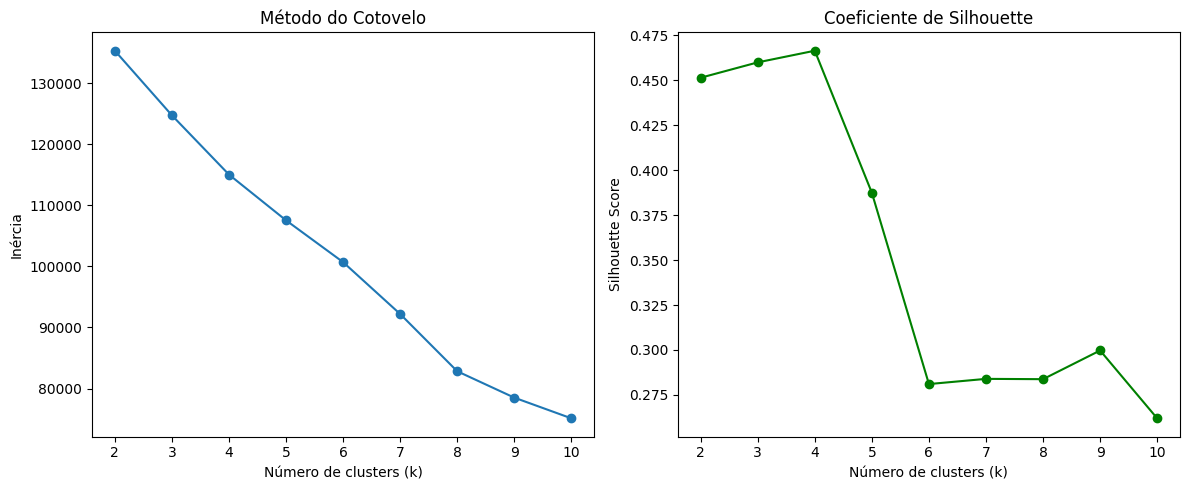

In [ ]:
# ======================
# 5. Elbow Method + Silhouette
# ======================
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# ======================
# 6. Visualizar resultados
# ======================
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Elbow Method
axes[0].plot(K, inertia, "o-")
axes[0].set_xlabel("Número de clusters (k)")
axes[0].set_ylabel("Inércia")
axes[0].set_title("Método do Cotovelo")

# Silhouette Score
axes[1].plot(K, silhouette_scores, "o-", color="green")
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Coeficiente de Silhouette")

plt.tight_layout()
plt.show()

In [60]:
from sklearn.cluster import KMeans

k = 10 # ajuste depois usando Elbow/Silhouette
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# ==============================
# 8. Atribuir clusters de volta
# ==============================
df_clientes_modelo["cluster"] = labels

# ==============================
# 9. Análises iniciais dos clusters
# ==============================
print("\nDistribuição de clientes por cluster:")
print(df_clientes_modelo["cluster"].value_counts(normalize=True).mul(100).round(2))
print(df_clientes_modelo["cluster"].value_counts())

print("\nMédias por cluster:")
print(df_clientes_modelo.groupby("cluster")[features_num].mean().round(2))


Distribuição de clientes por cluster:
cluster
3    40.35
2    23.24
0    12.16
1    11.95
8     8.01
4     2.33
7     1.02
6     0.54
9     0.40
5     0.01
Name: proportion, dtype: float64
cluster
3    4283
2    2467
0    1291
1    1269
8     850
4     247
7     108
6      57
9      42
5       1
Name: count, dtype: int64

Médias por cluster:
         MESES_CADASTRO  QT_CONTRATACOES_12M  VL_CONTRATACOES_12M   MRR_12M  \
cluster                                                                       
0                173.47                 1.12              5848.58    864.15   
1                 71.27                 0.96              6687.98    618.07   
2                134.83                 0.60              2234.27    457.86   
3                 58.40                 0.39              1043.87    114.04   
4                162.36                 5.18             44554.52   2438.30   
5                 56.00                 1.00           3573278.76  42838.39   
6                 11.60

In [44]:
df_clientes_modelo

,MESES_CADASTRO,PAIS,UF_CLIENTE,FAT_FAIXA,DS_SEGMENTO,QT_CONTRATACOES_12M,VL_CONTRATACOES_12M,MRR_12M,NOTA_NPS,NOTA_RESPOSTA_UNIDADE,...,NOTA_ADMFIN_ATENDIMENTO,NOTA_SOFTWARE,NOTA_SOFTWARE_ATUALIZACAO,TICKETS,NOTA_NPS_ONBOARDING,NOTA_NPS_IMPLANTACAO,NOTA_NPS_AQUISICAO,NOTA_NPS_SUPORTE,NOTA_NPS_PRODUTO,cluster
COD_CLIENTE,,,,,,,,,,,,,,,,,,,,,
TFDICB,31,BRASIL,ES,Faixa 03 - De 15 M ate 25 M,VAREJO,0.0,0.000000,433.972837,0.000000,0.00,...,0.0,0.0,0.000000,369.0,0.0,0.0,0.0,0.000000,0.000000,1
TFCU91,55,BRASIL,PR,"Faixa 00 - Ate 4,5 M",LOGISTICA,0.0,0.000000,1189.643775,0.000000,0.00,...,0.0,0.0,0.000000,68.0,0.0,0.0,0.0,0.000000,0.000000,1
TFDDYV,37,BRASIL,SP,Sem Informações de Faturamento,MANUFATURA,0.0,0.000000,486.228287,0.000000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1
TEZBRW,34,BRASIL,MG,Sem Informações de Faturamento,SERVICOS,0.0,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1
TEZCXN,148,BRASIL,RS,Faixa 07 - De 75 M ate 150 M,MANUFATURA,3.0,22556.641683,1821.202084,0.000000,0.00,...,0.0,0.0,0.000000,709.0,0.0,0.0,0.0,9.902256,7.826087,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TFDNXR,26,BRASIL,PB,Sem Informações de Faturamento,VAREJO,0.0,0.000000,55.860533,0.000000,0.00,...,0.0,0.0,0.000000,29.0,0.0,0.0,0.0,0.000000,0.000000,1
TFBYAZ,251,BRASIL,SP,Sem Informações de Faturamento,HOSPITALITY,0.0,0.000000,363.179254,6.666667,6.50,...,8.0,10.0,7.333333,67.0,0.0,0.0,0.0,6.400000,0.000000,0
T04630,350,BRASIL,SP,"Faixa 02 - De 7,5 M ate 15 M",SERVICOS,0.0,0.000000,64.340569,9.000000,9.25,...,0.0,0.0,0.000000,7.0,0.0,0.0,0.0,0.000000,8.500000,1


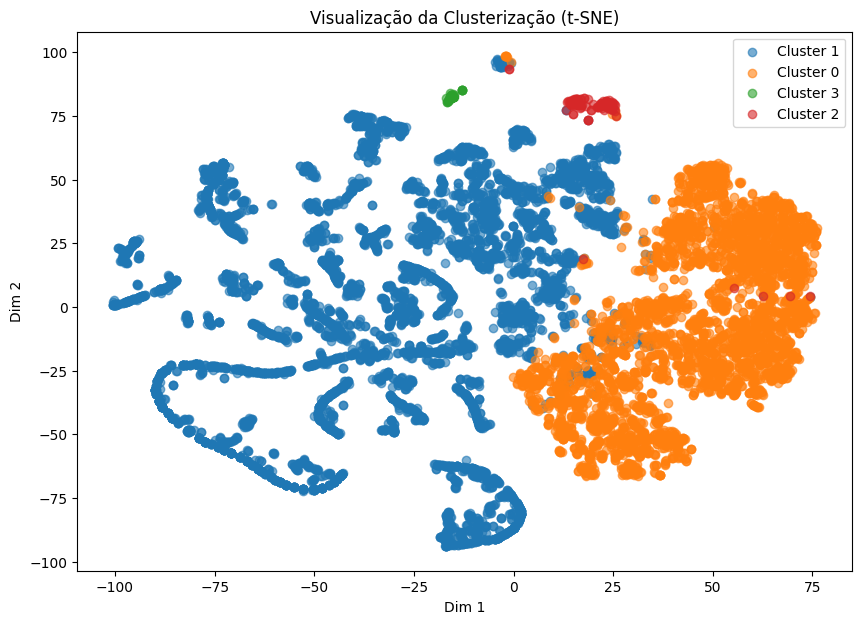

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

df_plot = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"], index=df_clientes_modelo.index)
df_plot["cluster"] = df_clientes_modelo["cluster"]

plt.figure(figsize=(10,7))
for c in df_plot["cluster"].unique():
    subset = df_plot[df_plot["cluster"] == c]
    plt.scatter(
        subset["Dim1"], subset["Dim2"], 
        label=f"Cluster {c}", alpha=0.6
    )

plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.title("Visualização da Clusterização (t-SNE)")
plt.legend()
plt.show()

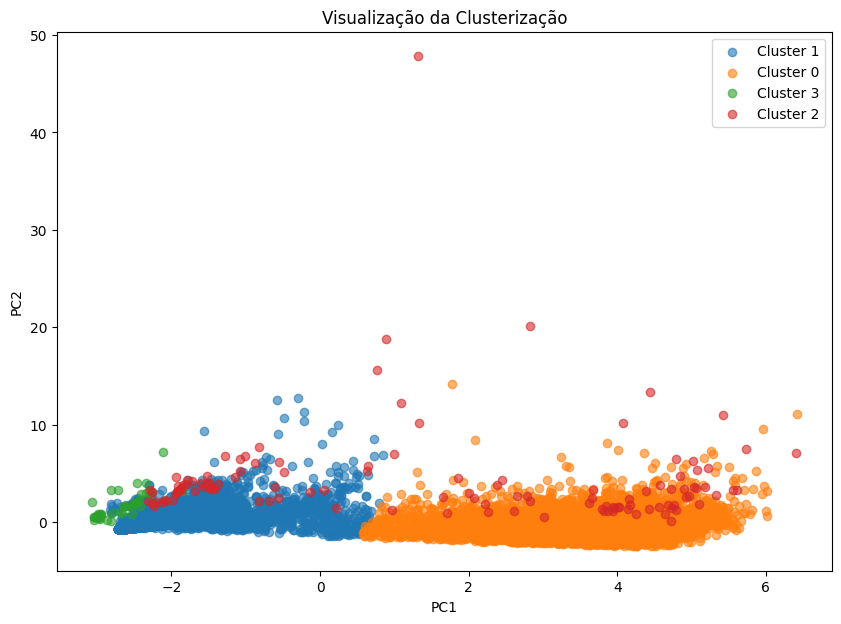

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supondo que X seja sua matriz de features escaladas
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_clientes_modelo.index)
df_plot["cluster"] = df_clientes_modelo["cluster"]  # clusters atribuídos

plt.figure(figsize=(10,7))
for c in df_plot["cluster"].unique():
    subset = df_plot[df_plot["cluster"] == c]
    plt.scatter(
        subset["PC1"], subset["PC2"], 
        label=f"Cluster {c}", alpha=0.6
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualização da Clusterização")
plt.legend()
plt.show()